In [104]:
import io, requests, glob, os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [105]:
# Plot a parameter of a dataframe
def plot_param(params, title, data):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [106]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

# Calculate the diff values. We have 10 Countries (9 + Austria in general)
# so the last value is 10 lines above.
data["TestungenPCRTaeglich"] = data["TestungenPCR"].diff(periods=10)
data["HospitalisierungTaeglich"] = data["Hospitalisierung"].diff(periods=10)
data["Neuinfektionen"] = data["BestaetigteFaelleBundeslaender"].diff(
    periods=10)
data["Positivrate"] = data.apply(lambda row: np.nan if row["TestungenPCRTaeglich"] == 0 else row["Neuinfektionen"] * 100000 / row["TestungenPCRTaeglich"], axis=1)
# Subtract 1 day (values are published on the next day in the morning)
data["Datum"] = pd.to_datetime(data["Datum"], utc=True).dt.date + pd.DateOffset(days=-1)
for bl in data["Name"].unique():
    # Basic outlier detection: remove values which are higher then the mean value + 5 * standard deviation
    for param in ["TestungenPCRTaeglich", "HospitalisierungTaeglich", "Hospitalisierung", "Neuinfektionen", "Positivrate"]:
        mean = data.loc[data["Name"] == bl, param].mean()
        stdev = data.loc[data["Name"] == bl, param].std()
        minVal = 0 if (param == "TestungenPCRTaeglich" or param ==
                       "Neuinfektionen" or param == "Positivrate") else mean - 5 * stdev
        maxVal = mean + 5 * stdev
        data.loc[(data["Name"] == bl) & ((data[param] < minVal)
                                         | (data[param] > maxVal)), param] = np.nan
        data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")

    # Fill na values for first diff.
    data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
data.to_csv("timeline-faelle-bundeslaender.csv", encoding='utf-8', index=False)


In [107]:
data = pd.read_csv("timeline-faelle-bundeslaender.csv",
                   encoding='utf-8', parse_dates=[0])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)


## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

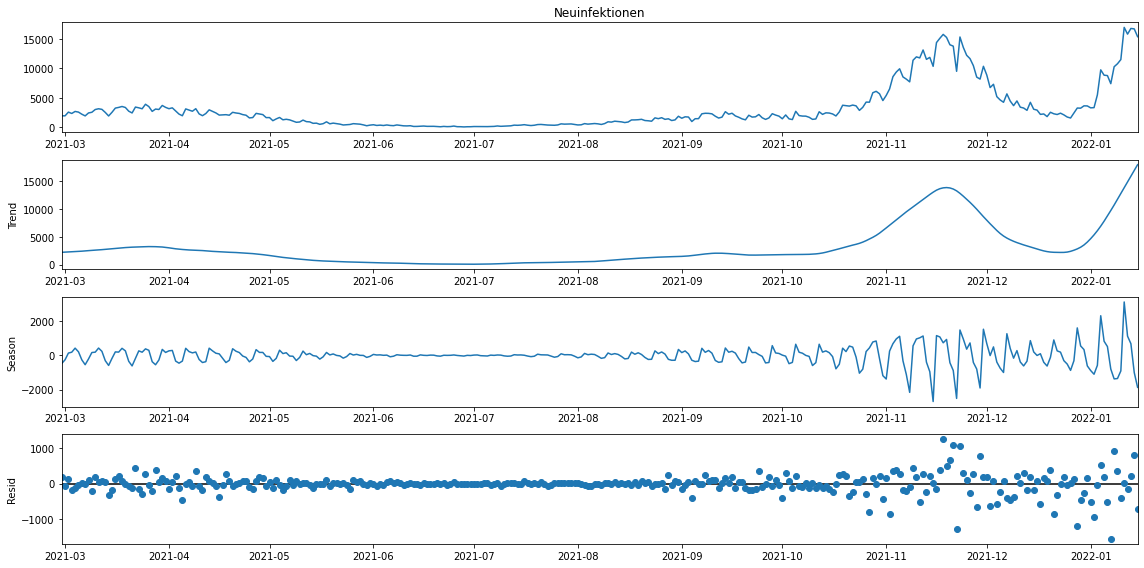

In [108]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [109]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst, columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,Neuinfektionen
2022-01-16,17500.685630
2022-01-17,18008.449839
2022-01-18,23315.812592
2022-01-19,21943.487536
2022-01-20,22693.391044
2022-01-21,22378.965314
2022-01-22,20994.211304


## Hospitalisierung
### Werte der letzten 7 Tage

In [110]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(8*10)["Hospitalisierung"].diff(periods=10).tail(7*10)
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-09,45 (-1),95 (7),125 (-4),98 (6),56 (-1),86 (-2),117 (3),41 (6),272 (10),935 (24)
2022-01-10,47 (2),87 (-8),117 (-8),92 (-6),64 (8),96 (10),122 (5),39 (-2),264 (-8),928 (-7)
2022-01-11,44 (-3),87 (0),114 (-3),91 (-1),63 (-1),96 (0),113 (-9),29 (-10),272 (8),909 (-19)
2022-01-12,42 (-2),83 (-4),111 (-3),90 (-1),62 (-1),93 (-3),112 (-1),29 (0),267 (-5),889 (-20)
2022-01-13,39 (-3),79 (-4),107 (-4),93 (3),60 (-2),95 (2),111 (-1),29 (0),290 (23),903 (14)
2022-01-14,39 (0),71 (-8),106 (-1),93 (0),60 (0),93 (-2),120 (9),28 (-1),280 (-10),890 (-13)
2022-01-15,35 (-4),75 (4),108 (2),93 (0),58 (-2),86 (-7),113 (-7),31 (3),284 (4),883 (-7)


### Diagramm

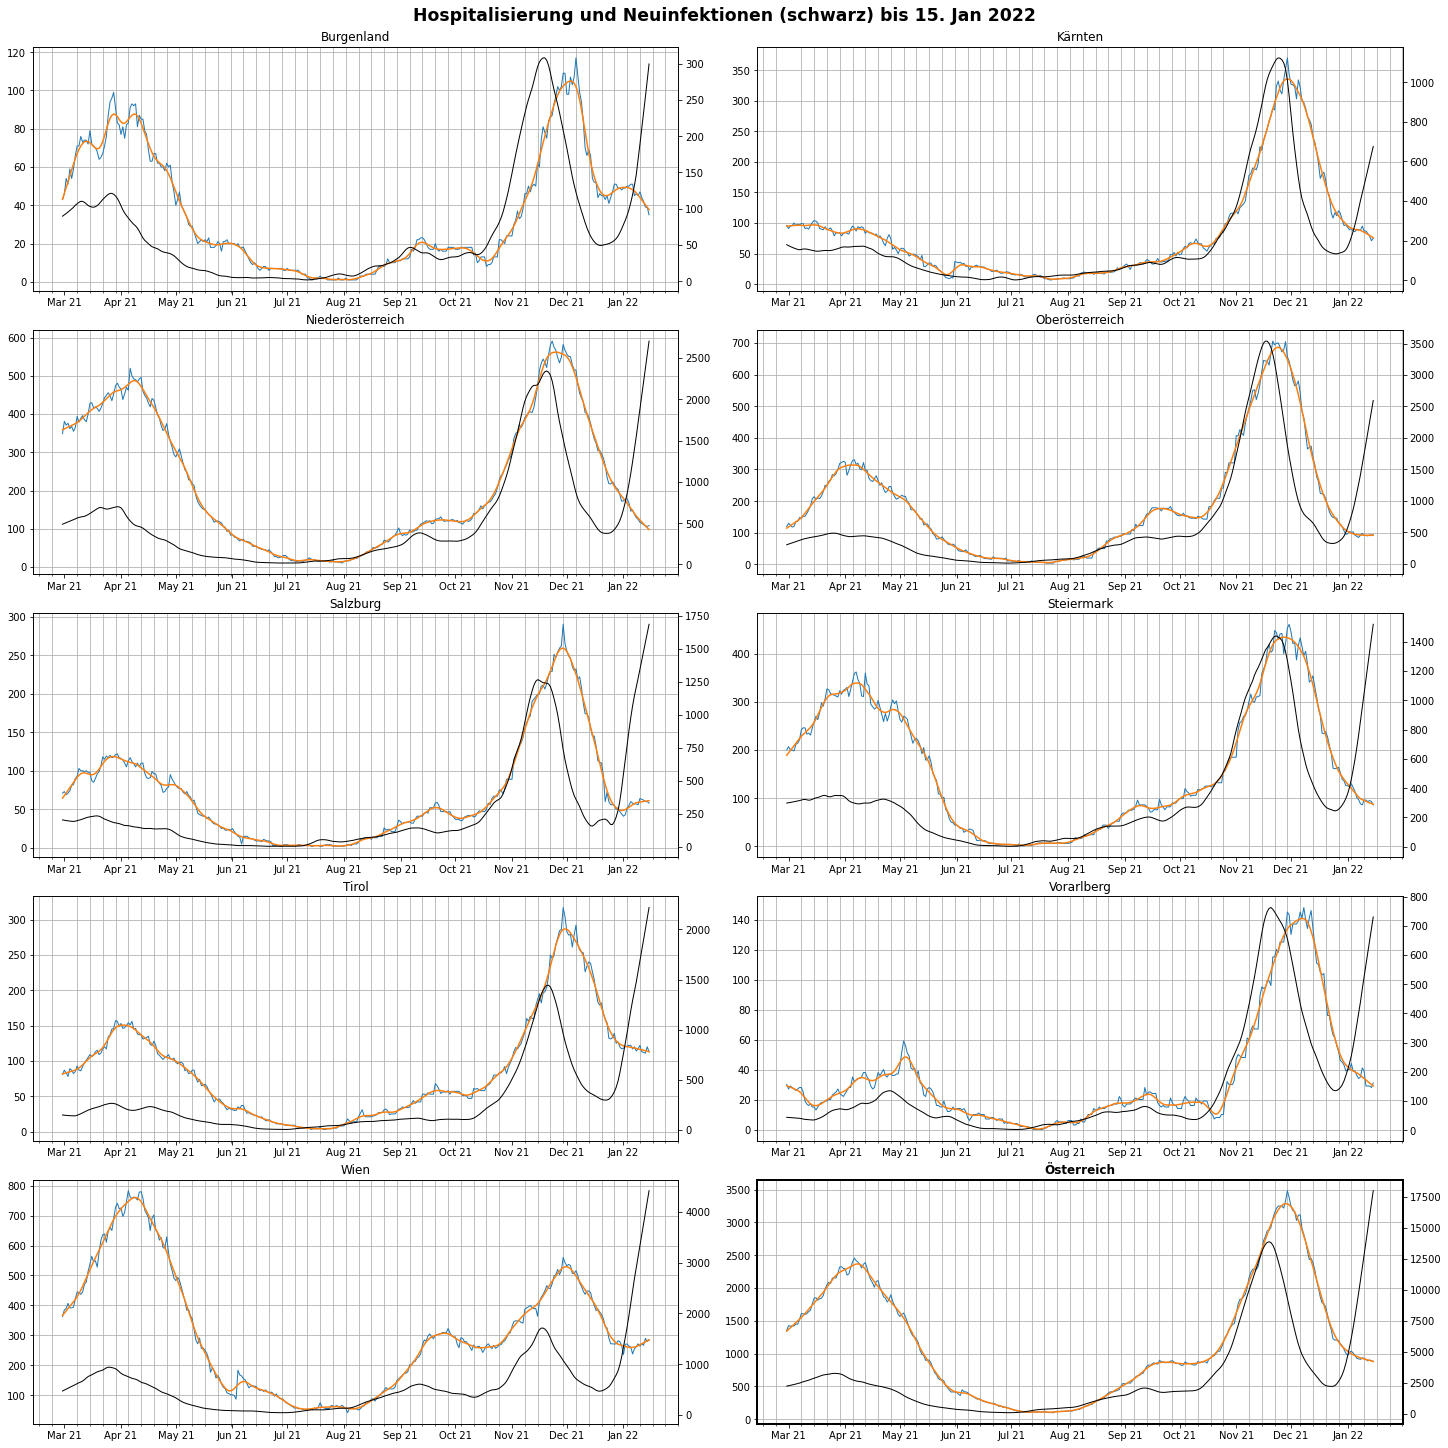

In [111]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [112]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCRTaeglich": data.tail(7*10)["TestungenPCRTaeglich"],
        "Diff": data.tail(8*10)["TestungenPCRTaeglich"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCRTaeglich:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-09,11 585 (9 719),8 314 (-2 495),18 838 (169),43 577 (1 300),16 700 (-7 685),34 189 (10 287),12 268 (-5 750),10 104 (324),321 899 (93 762),477 474 (87 372)
2022-01-10,12 697 (1 112),8 265 (-49),19 012 (174),42 003 (-1 574),7 026 (-9 674),26 207 (-7 982),24 748 (12 480),5 998 (-4 106),285 848 (-36 051),431 804 (-45 670)
2022-01-11,9 000 (-3 697),7 465 (-800),320 653 (301 641),51 266 (9 263),29 020 (21 994),7 340 (-18 867),20 364 (-4 384),9 710 (3 712),449 766 (163 918),904 584 (472 780)
2022-01-12,10 968 (1 968),10 523 (3 058),24 837 (-295 816),39 784 (-11 482),25 853 (-3 167),11 567 (4 227),21 440 (1 076),7 754 (-1 956),253 822 (-195 944),406 548 (-498 036)
2022-01-13,7 008 (-3 960),14 227 (3 704),25 294 (457),48 252 (8 468),21 009 (-4 844),58 575 (47 008),21 125 (-315),9 337 (1 583),424 587 (170 765),629 414 (222 866)
2022-01-14,8 281 (1 273),6 637 (-7 590),26 660 (1 366),37 426 (-10 826),19 503 (-1 506),33 278 (-25 297),22 260 (1 135),7 722 (-1 615),275 902 (-148 685),437 669 (-191 745)
2022-01-15,11 893 (3 612),5 637 (-1 000),27 778 (1 118),41 445 (4 019),20 051 (548),30 689 (-2 589),26 442 (4 182),6 909 (-813),217 379 (-58 523),388 223 (-49 446)


### Diagramm

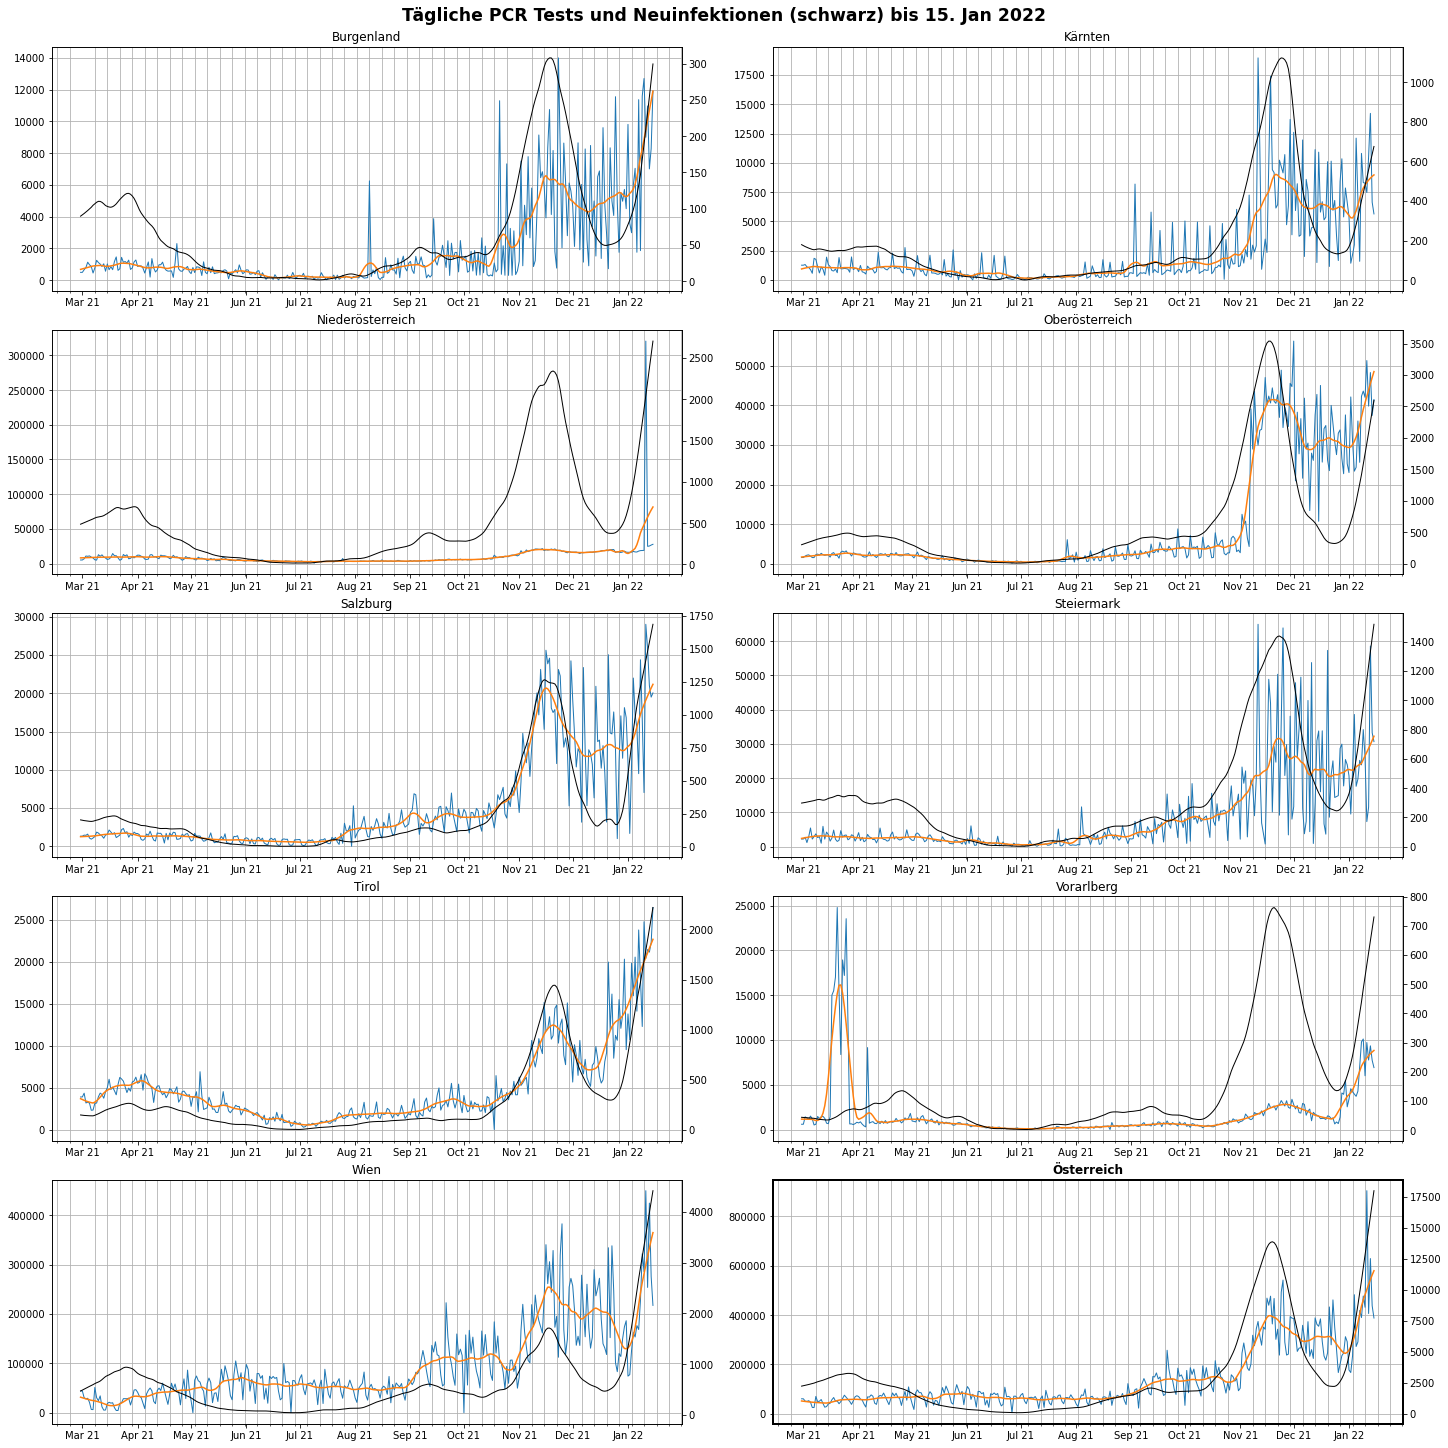

In [113]:

plot_param(["TestungenPCRTaeglich", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)
